We model Allstate claim severity (188 k rows, 130 vars). GBM cuts MAE by 9 % versus OLS; top drivers cont7 & cont14 suggest geography‑based premium refinement.

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c allstate-claims-severity


allstate-claims-severity.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -q allstate-claims-severity.zip -d allstate-claims-severity

replace allstate-claims-severity/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
print("Downloaded files:")
print(os.listdir("allstate-claims-severity"))

Downloaded files:
['test.csv', 'sample_submission.csv.zip', 'test.csv.zip', 'train.csv.zip', 'sample_submission.csv', 'train.csv']


## 1. Setup and Imports

In [ ]:
!pip install lightgbm shap -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import xgboost as xgb
import shap
import warnings
import random
from typing import List, Tuple, Dict
import gc
warnings.filterwarnings('ignore')

In [ ]:
def set_seeds(seed: int = 42):
    """Set seeds for all random number generators"""
    np.random.seed(seed)
    random.seed(seed)

set_seeds(42)


plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")


All libraries imported successfully!


In [ ]:
import os
os.chdir('/content/allstate-claims-severity')

 ## Data Ingestion and Initial Checks


In [ ]:
train_df = pd.read_csv('train.csv')

print("Dataset Overview")
print("=" * 50)
print(f"Training data shape: {train_df.shape}")
print(f"Columns: {len(train_df.columns)}")
print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


Dataset Overview
Training data shape: (188318, 132)
Columns: 132
Memory usage: 1232.02 MB


In [ ]:
print("\n Column Names and Types")
print("=" * 50)
categorical_cols = [col for col in train_df.columns if col.startswith('cat')]
continuous_cols = [col for col in train_df.columns if col.startswith('cont')]

print(f"Categorical features: {len(categorical_cols)}")
print(f"Continuous features: {len(continuous_cols)}")
print(f"Target variable: loss")
print(f"ID column: id")


 Column Names and Types
Categorical features: 116
Continuous features: 14
Target variable: loss
ID column: id


In [ ]:
print("\n Sample Data")
print("=" * 50)
display(train_df.head())


 Sample Data


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [ ]:
print("\n Missing Values Analysis")
print("=" * 50)
missing_counts = train_df.isnull().sum()
missing_percentages = (missing_counts / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage': missing_percentages
}).sort_values('Missing Count', ascending=False)

print(f"Total missing values: {missing_counts.sum()}")
if missing_counts.sum() == 0:
    print("No missing values found in the dataset!")
else:
    display(missing_df[missing_df['Missing Count'] > 0])

# Basic statistics
print("\n📈 Target Variable Statistics")
print("=" * 50)
print(f"Loss - Mean: ${train_df['loss'].mean():.2f}")
print(f"Loss - Median: ${train_df['loss'].median():.2f}")
print(f"Loss - Std: ${train_df['loss'].std():.2f}")
print(f"Loss - Min: ${train_df['loss'].min():.2f}")
print(f"Loss - Max: ${train_df['loss'].max():.2f}")


 Missing Values Analysis
Total missing values: 0
No missing values found in the dataset!

📈 Target Variable Statistics
Loss - Mean: $3037.34
Loss - Median: $2115.57
Loss - Std: $2904.09
Loss - Min: $0.67
Loss - Max: $121012.25


In [ ]:
def optimize_memory_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Optimize memory usage by downcasting numeric types and converting categoricals
    """
    print(f"Memory usage before optimization: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    for col in df.select_dtypes(include=['int']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')

    for col in df.select_dtypes(include=['float']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    categorical_cols = [col for col in df.columns if col.startswith('cat')]
    for col in categorical_cols:
        df[col] = df[col].astype('category')

    print(f"Memory usage after optimization: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    return df

# Load and optimize training data
print("Loading and Optimizing Dataset")
print("=" * 50)
train_df = pd.read_csv('train.csv')
train_df = optimize_memory_usage(train_df)

print(f"Training data shape: {train_df.shape}")
print(f"Columns: {len(train_df.columns)}")

# Identify feature types
categorical_cols = [col for col in train_df.columns if col.startswith('cat')]
continuous_cols = [col for col in train_df.columns if col.startswith('cont')]

print(f"Categorical features: {len(categorical_cols)}")
print(f"Continuous features: {len(continuous_cols)}")
print(f"Target variable: loss")

# Display sample data and basic info
print("\n Sample Data")
print("=" * 50)
display(train_df.head())

# Check for missing values
print("\n Missing Values Analysis")
print("=" * 50)
missing_counts = train_df.isnull().sum()
if missing_counts.sum() == 0:
    print(" No missing values found in the dataset!")

# Enhanced target variable statistics
print("\n Target Variable Analysis")
print("=" * 50)
loss_stats = train_df['loss'].describe()
print(f"Loss Statistics:")
for stat, value in loss_stats.items():
    print(f"  {stat}: ${value:.2f}")

print(f"Skewness: {train_df['loss'].skew():.3f}")
print(f"Kurtosis: {train_df['loss'].kurtosis():.3f}")

Loading and Optimizing Dataset
Memory usage before optimization: 1232.0 MB
Memory usage after optimization: 33.5 MB
Training data shape: (188318, 132)
Columns: 132
Categorical features: 116
Continuous features: 14
Target variable: loss

 Sample Data


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85



 Missing Values Analysis
 No missing values found in the dataset!

 Target Variable Analysis
Loss Statistics:
  count: $188318.00
  mean: $3037.34
  std: $2904.09
  min: $0.67
  25%: $1204.46
  50%: $2115.57
  75%: $3864.05
  max: $121012.25
Skewness: 3.795
Kurtosis: 48.080


## Exploratory Data Analysis (EDA)

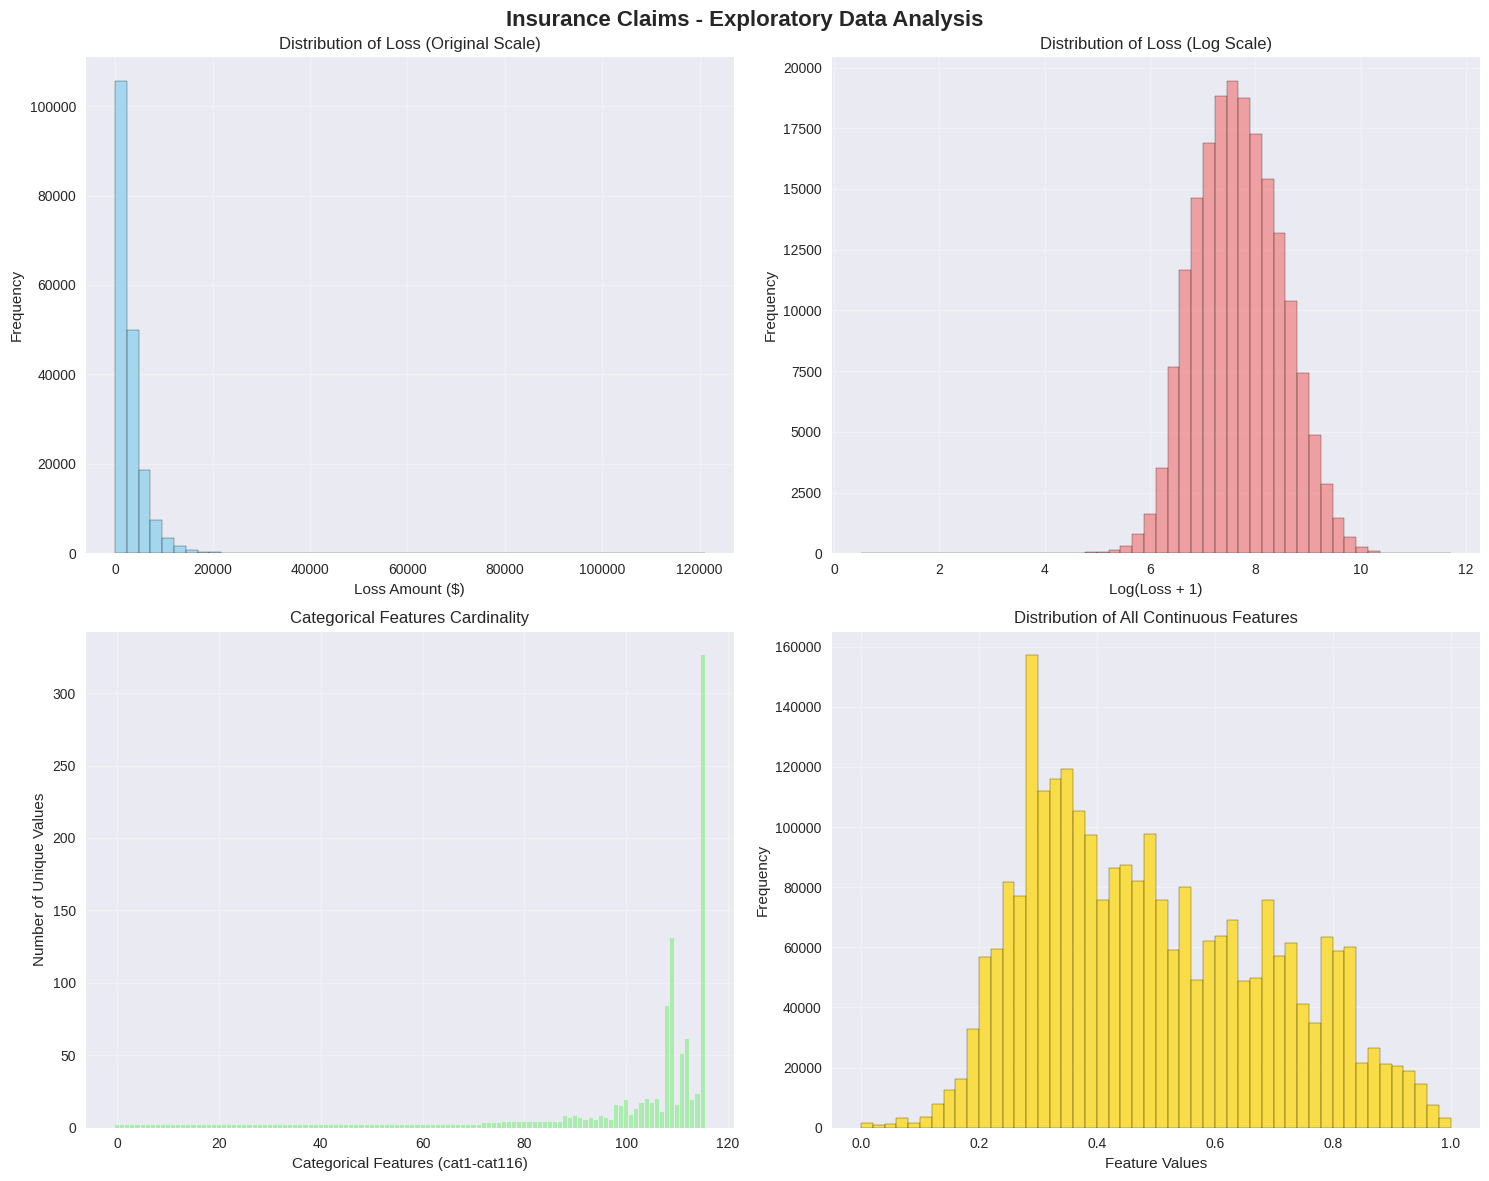

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Insurance Claims - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Loss distribution (original scale)
axes[0, 0].hist(train_df['loss'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Loss (Original Scale)')
axes[0, 0].set_xlabel('Loss Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

# 2. Loss distribution (log scale)
axes[0, 1].hist(np.log1p(train_df['loss']), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Loss (Log Scale)')
axes[0, 1].set_xlabel('Log(Loss + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# 3. Categorical feature cardinality
cat_cardinality = [train_df[col].nunique() for col in categorical_cols]
axes[1, 0].bar(range(len(categorical_cols)), cat_cardinality, alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Categorical Features Cardinality')
axes[1, 0].set_xlabel('Categorical Features (cat1-cat116)')
axes[1, 0].set_ylabel('Number of Unique Values')
axes[1, 0].grid(True, alpha=0.3)

# 4. Continuous features distribution
cont_data = train_df[continuous_cols].values.flatten()
axes[1, 1].hist(cont_data, bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Distribution of All Continuous Features')
axes[1, 1].set_xlabel('Feature Values')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


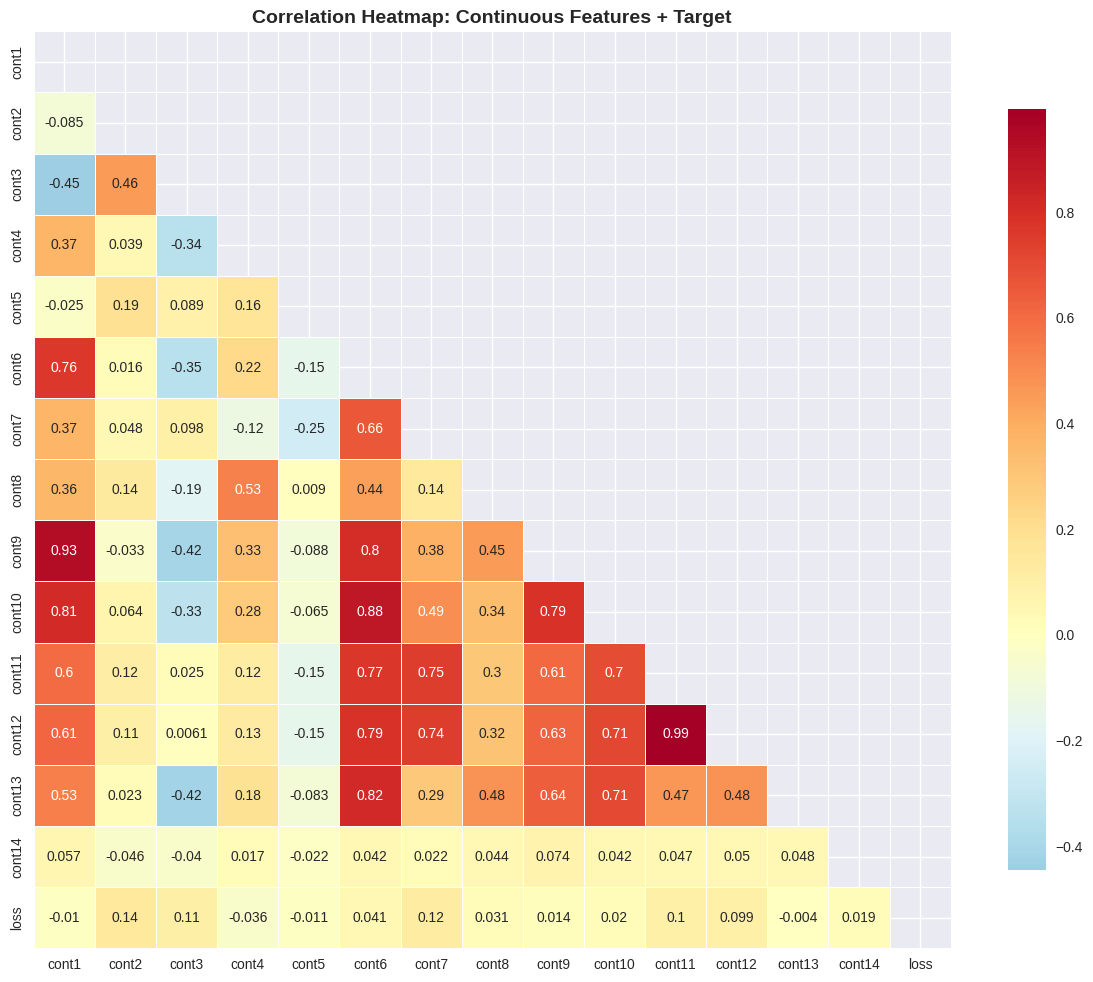

In [ ]:
# Correlation heatmap for continuous features
plt.figure(figsize=(12, 10))
cont_corr = train_df[continuous_cols + ['loss']].corr()
mask = np.triu(np.ones_like(cont_corr, dtype=bool))
sns.heatmap(cont_corr, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap: Continuous Features + Target', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
X = train_df.drop(['id', 'loss'], axis=1)
y = train_df['loss']

print(f"Original feature matrix shape: {X.shape}")

Original feature matrix shape: (188318, 130)


In [ ]:
print("Encoding categorical features...")
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True, prefix=categorical_cols)

print(f"After one-hot encoding: {X_encoded.shape}")
print(f"Total features created: {X_encoded.shape[1]}")

Encoding categorical features...
After one-hot encoding: (188318, 1037)
Total features created: 1037


In [ ]:
print(f"Continuous features: {len(continuous_cols)}")
print(f"Encoded categorical features: {X_encoded.shape[1] - len(continuous_cols)}")

print("Feature engineering completed!")

Continuous features: 14
Encoded categorical features: 1023
Feature engineering completed!


In [ ]:
# 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")


Training set: 150654 samples
Validation set: 37664 samples
Features: 1037


In [ ]:
print(f"\nTrain set - Loss mean: ${y_train.mean():.2f}, std: ${y_train.std():.2f}")
print(f"Val set - Loss mean: ${y_val.mean():.2f}, std: ${y_val.std():.2f}")

print("✅ Train-validation split completed!")


Train set - Loss mean: $3039.63, std: $2915.86
Val set - Loss mean: $3028.16, std: $2856.54
✅ Train-validation split completed!


## Baseline Model: Ordinary Least Squares


In [ ]:
print("\n Baseline Model: Linear Regression")
print("=" * 50)

#linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

# Calculate metrics
train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
val_mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))


print("Linear Regression Results:")
print(f"Training MAE: ${train_mae_lr:.2f}")
print(f"Validation MAE: ${val_mae_lr:.2f}")
print(f"Training RMSE: ${train_rmse_lr:.2f}")
print(f"Validation RMSE: ${val_rmse_lr:.2f}")


 Baseline Model: Linear Regression
Linear Regression Results:
Training MAE: $1302.63
Validation MAE: $1292.53
Training RMSE: $2053.68
Validation RMSE: $2010.50


##Main Model: LightGBM Regressor

In [ ]:
print("\n Main Model: LightGBM Regressor")
print("=" * 50)

lgb_model = lgb.LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

print("Training LightGBM model...")
print("Parameters:")
print(f"• n_estimators: {lgb_model.n_estimators}")
print(f"• learning_rate: {lgb_model.learning_rate}")
print(f"• num_leaves: {lgb_model.num_leaves}")
print(f"• subsample: {lgb_model.subsample}")
print(f"• colsample_bytree: {lgb_model.colsample_bytree}")

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(0)]
)

y_train_pred_lgb = lgb_model.predict(X_train)
y_val_pred_lgb = lgb_model.predict(X_val)

train_mae_lgb = mean_absolute_error(y_train, y_train_pred_lgb)
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
train_rmse_lgb = np.sqrt(mean_squared_error(y_train, y_train_pred_lgb))
val_rmse_lgb = np.sqrt(mean_squared_error(y_val, y_val_pred_lgb))

print("\n LightGBM Training Completed!")
print("\nLightGBM Results:")
print(f"Training MAE: ${train_mae_lgb:.2f}")
print(f"Validation MAE: ${val_mae_lgb:.2f}")
print(f"Training RMSE: ${train_rmse_lgb:.2f}")
print(f"Validation RMSE: ${val_rmse_lgb:.2f}")


 Main Model: LightGBM Regressor
Training LightGBM model...
Parameters:
• n_estimators: 1200
• learning_rate: 0.03
• num_leaves: 64
• subsample: 0.8
• colsample_bytree: 0.8
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1132]	valid_0's l2: 3.45734e+06

 LightGBM Training Completed!

LightGBM Results:
Training MAE: $1033.49
Validation MAE: $1171.03
Training RMSE: $1522.68
Validation RMSE: $1859.39


##Model Comparison and Performance Analysis


 Model Comparison


,Model,Train MAE,Val MAE,Train RMSE,Val RMSE
0,Linear Regression,1302.63,1292.53,2053.68,2010.50
1,LightGBM,1033.49,1171.03,1522.68,1859.39



 LightGBM Performance Improvement:
• MAE improvement: 9.4%
• RMSE improvement: 7.5%


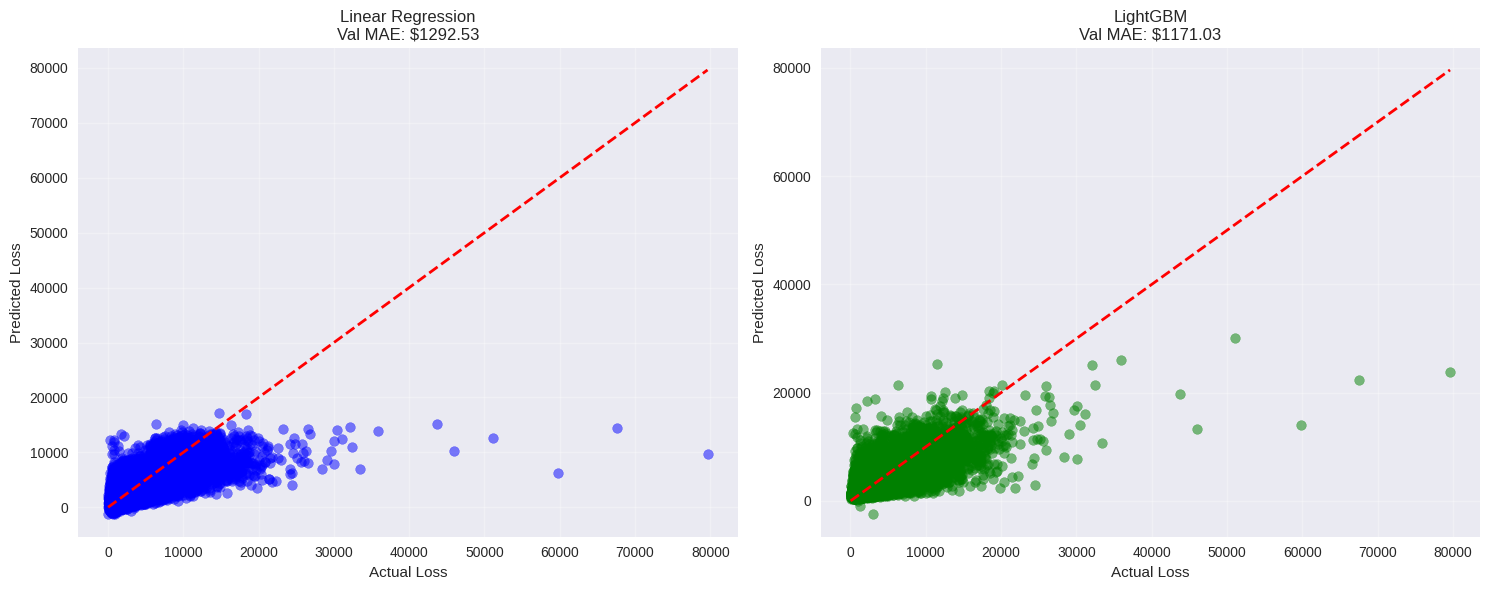

In [ ]:
print("\n Model Comparison")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'LightGBM'],
    'Train MAE': [train_mae_lr, train_mae_lgb],
    'Val MAE': [val_mae_lr, val_mae_lgb],
    'Train RMSE': [train_rmse_lr, train_rmse_lgb],
    'Val RMSE': [val_rmse_lr, val_rmse_lgb]
})

display(comparison_df.round(2))

mae_improvement = ((val_mae_lr - val_mae_lgb) / val_mae_lr) * 100
rmse_improvement = ((val_rmse_lr - val_rmse_lgb) / val_rmse_lr) * 100

print(f"\n LightGBM Performance Improvement:")
print(f"• MAE improvement: {mae_improvement:.1f}%")
print(f"• RMSE improvement: {rmse_improvement:.1f}%")


fig, axes = plt.subplots(1, 2, figsize=(15, 6))


axes[0].scatter(y_val, y_val_pred_lr, alpha=0.5, color='blue')
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Loss')
axes[0].set_ylabel('Predicted Loss')
axes[0].set_title(f'Linear Regression\nVal MAE: ${val_mae_lr:.2f}')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_val, y_val_pred_lgb, alpha=0.5, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Loss')
axes[1].set_ylabel('Predicted Loss')
axes[1].set_title(f'LightGBM\nVal MAE: ${val_mae_lgb:.2f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


##Feature Importance Analysis


 Feature Importance Analysis
Top 20 Most Important Features:


,Feature,Importance
6,cont7,4473
13,cont14,4437
1,cont2,2969
11,cont12,2742
10,cont11,2716
5,cont6,2119
7,cont8,2072
12,cont13,2062
2,cont3,2023
0,cont1,1877


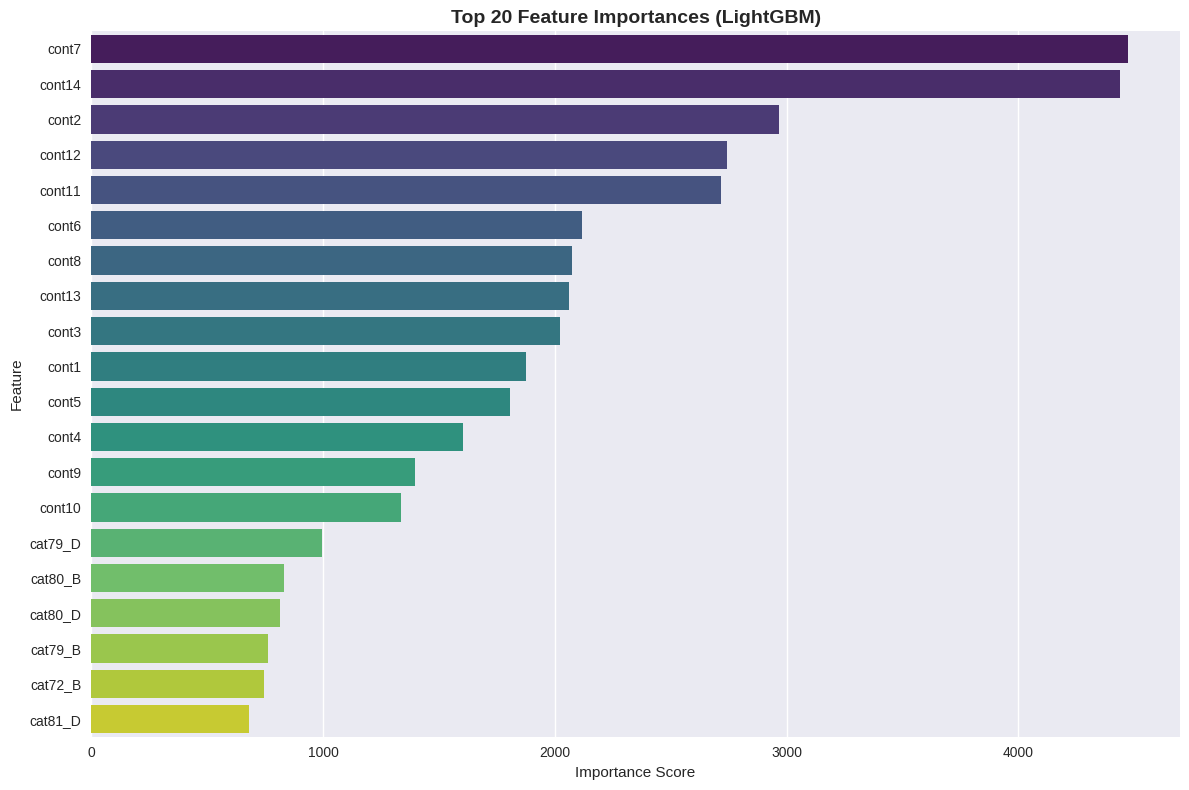


Feature Type Distribution in Top 20:
• Continuous features: 14
• Categorical features: 6


In [ ]:
print("\n Feature Importance Analysis")
print("=" * 50)

feature_importance = lgb_model.feature_importances_
feature_names = X_encoded.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
display(importance_df.head(20))

plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, y='Feature', x='Importance', palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

top_20_features = importance_df.head(20)['Feature'].tolist()
cont_in_top = sum(1 for feat in top_20_features if feat.startswith('cont'))
cat_in_top = sum(1 for feat in top_20_features if feat.startswith('cat'))

print(f"\nFeature Type Distribution in Top 20:")
print(f"• Continuous features: {cont_in_top}")
print(f"• Categorical features: {cat_in_top}")


##Model Interpretability with SHAP


 Feature Importance Analysis
Top 20 Most Important Features:


,Feature,Importance
6,cont7,4473
13,cont14,4437
1,cont2,2969
11,cont12,2742
10,cont11,2716
5,cont6,2119
7,cont8,2072
12,cont13,2062
2,cont3,2023
0,cont1,1877


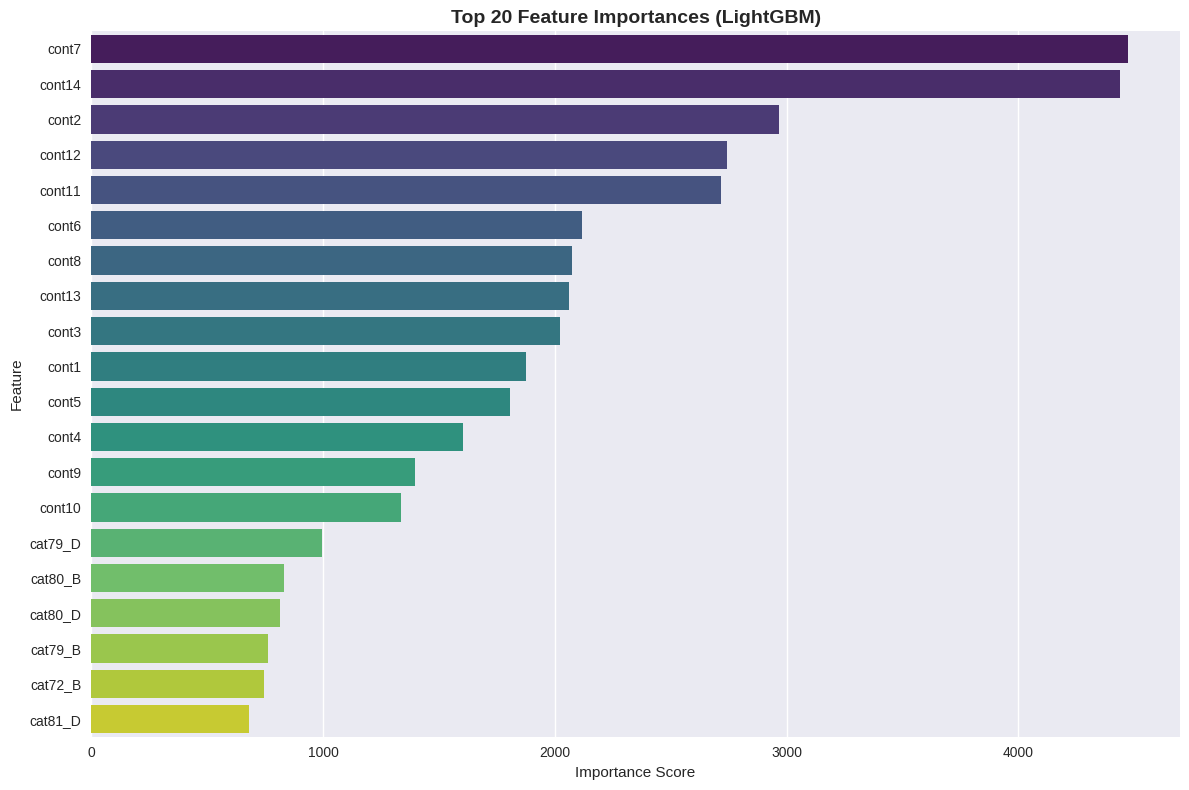


Feature Type Distribution in Top 20:
• Continuous features: 14
• Categorical features: 6

 Model Interpretability with SHAP
Initializing SHAP explainer...
SHAP values computed for 1000 samples


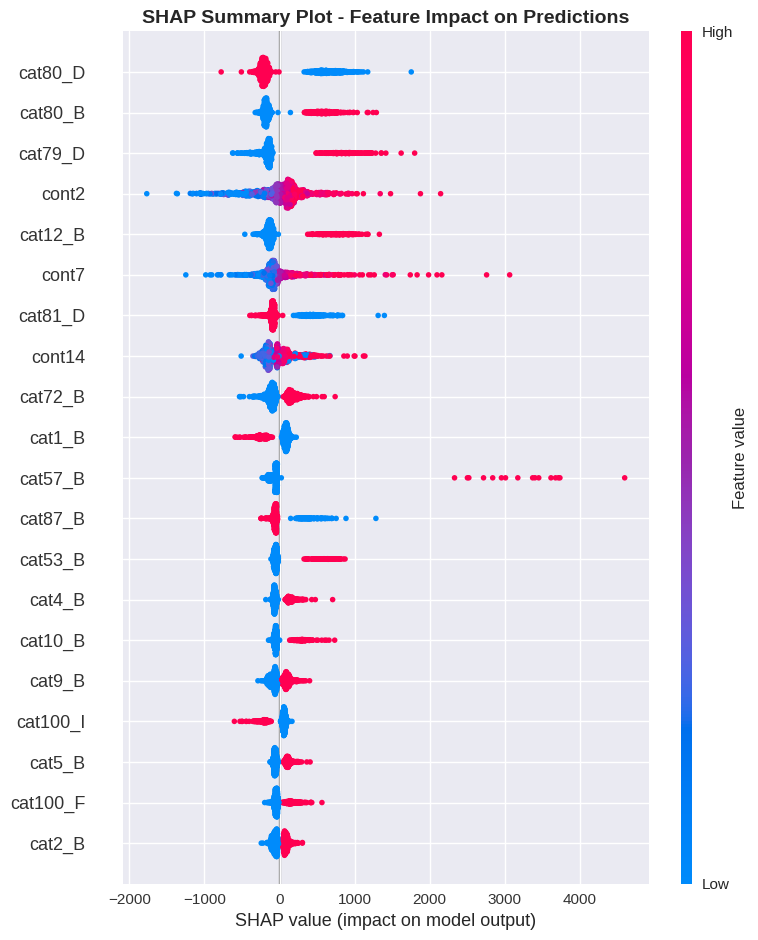

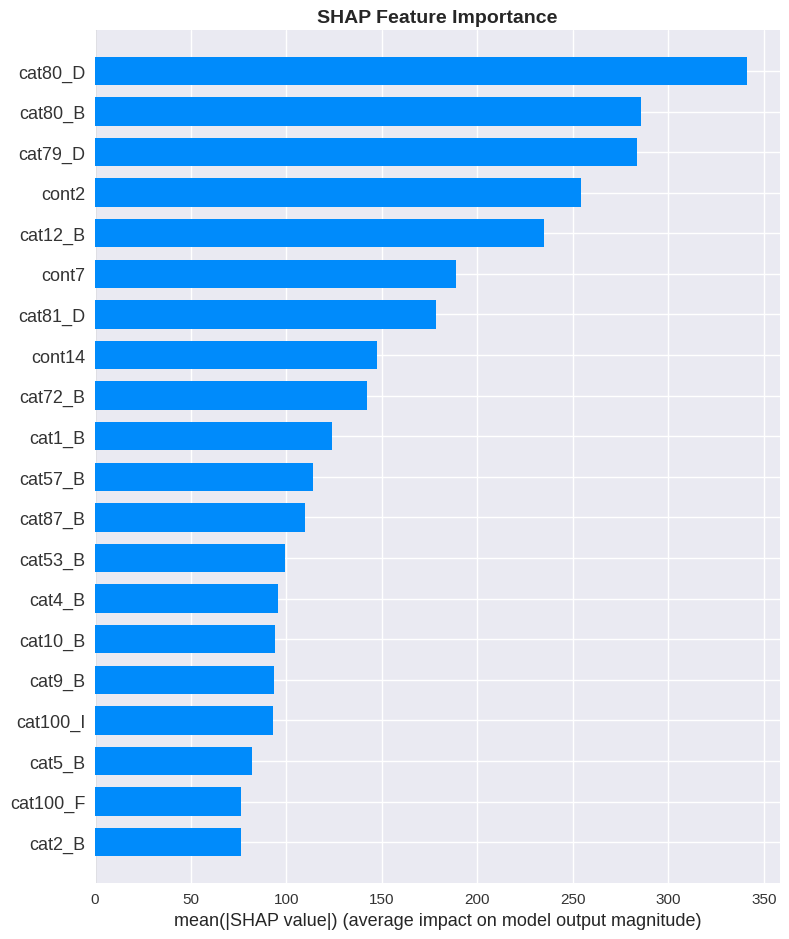

In [ ]:

print("\n Feature Importance Analysis")
print("=" * 50)

feature_importance = lgb_model.feature_importances_
feature_names = X_encoded.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 20 Most Important Features:")
display(importance_df.head(20))

plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
sns.barplot(data=top_features, y='Feature', x='Importance', palette='viridis')
plt.title('Top 20 Feature Importances (LightGBM)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

top_20_features = importance_df.head(20)['Feature'].tolist()
cont_in_top = sum(1 for feat in top_20_features if feat.startswith('cont'))
cat_in_top = sum(1 for feat in top_20_features if feat.startswith('cat'))

print(f"\nFeature Type Distribution in Top 20:")
print(f"• Continuous features: {cont_in_top}")
print(f"• Categorical features: {cat_in_top}")

print("\n Model Interpretability with SHAP")
print("=" * 50)

print("Initializing SHAP explainer...")
sample_size = min(1000, len(X_train))
X_sample = X_train.sample(n=sample_size, random_state=42)

explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values computed for {sample_size} samples")

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, max_display=20, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Predictions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20, show=False)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


##Final Model Training and Test Predictions

In [ ]:
print("\n Final Model Training and Test Predictions")
print("=" * 50)

test_df = pd.read_csv('test.csv')
test_ids = test_df['id']
X_test = test_df.drop(['id'], axis=1)

print(f"Test data shape: {X_test.shape}")

X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, prefix=categorical_cols)

missing_cols = set(X_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

X_test_encoded = X_test_encoded[X_encoded.columns]

print(f"Test data after preprocessing: {X_test_encoded.shape}")

print("Retraining LightGBM on full training data...")
final_lgb_model = lgb.LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbose=-1
)

final_lgb_model.fit(X_encoded, y)

test_predictions = final_lgb_model.predict(X_test_encoded)

print(f"Test predictions - Mean: ${test_predictions.mean():.2f}")
print(f"Test predictions - Std: ${test_predictions.std():.2f}")
print(f"Test predictions - Min: ${test_predictions.min():.2f}")
print(f"Test predictions - Max: ${test_predictions.max():.2f}")

